In [230]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [231]:
class Deep_Neural_Network:
  def __init__(self,layers_dims,learning_rate=0.01,num_iterations=100,print_cost=False,activation="relu",optimizer="",batchSize=0):
    self.optimizer=optimizer.lower()
    self.beta1=0
    self.learning_rate=learning_rate
    self.activation=activation
    self.num_iterations=num_iterations
    self.X=0
    self.layers_dims=layers_dims
    self.Y=0
    self.Ym=0
    self.parameters={}
    self.costs=[]
    self.gradsOptimizer={}
    self.grads={}
    self.batchnorm_grads={}
    self.print_cost=print_cost
    self.m=0
    self.batch_size=batchSize
    self.mini_batches=[]
    self.accuracy=[]
    self.epsilon=1/(10**9)
  
  def fit(self,X,Y):
    self.X=X
    self.Y=Y
    self.m=Y.shape[1]
    self.M=self.m
    self.initialize_parameters()
    self.batch_size=self.m if(self.batch_size<=0 or self.batch_size>self.m) else self.batch_size
    self.create_batchs()
    for i in range(0, self.num_iterations):
      for (Xm,Ym) in self.mini_batches:
        self.Ym=Ym
        self.M=Ym.shape[1]
        Yorg=np.argmax(Ym,axis=0).reshape(1,Ym.shape[1])
        AL, caches,batchnorm_caches = self.L_model_forward(Xm,self.parameters)
        cost = self.compute_cost(AL,Ym)
        prediction=np.argmax(AL,axis=0)
        prediction=prediction.reshape(1,prediction.shape[0])
        acc=(np.sum(prediction==Yorg)/self.M)*100
        self.L_model_backward(AL, caches,batchnorm_caches)
        self.update_parameters()
        self.costs.append(cost)
        self.accuracy.append(acc)
      if self.print_cost and i % 100 == 0:
          print (f"Cost after iteration {i}: %f" %(cost))
    # plot the cost
    plt.plot(np.squeeze(self.costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(self.learning_rate))
    plt.show()
    plt.plot(np.squeeze(self.accuracy))
    plt.ylabel('accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(self.learning_rate))
    plt.show()
  
  def initialize_parameters(self):
    L=len(self.layers_dims)
    for i in range(1,L):
      self.parameters["W"+str(i)]=np.random.randn(self.layers_dims[i],self.layers_dims[i-1])*0.01
      self.init_optimizer_params(i)
      self.init_batch_norm_params(i)
    if self.optimizer=="momentum":
      self.beta1=0.9

  def init_optimizer_params(self,i):
    self.gradsOptimizer["vdW"+str(i)]=np.zeros((self.layers_dims[i],layers_dims[i-1]))

  def init_batch_norm_params(self,i):
    self.parameters["beta"+str(i)]=np.random.randn(self.layers_dims[i],1)*0.01
    self.parameters["gamma"+str(i)]=np.random.randn(self.layers_dims[i],1)*0.01
    self.parameters["mean"+str(i)]=np.zeros((self.layers_dims[i],1))
    self.parameters["var"+str(i)]=np.zeros((self.layers_dims[i],1))
  
  def create_batchs(self):
    X=self.X.T
    Y=self.Y.T
    n=self.m//self.batch_size
    n=n-1 if (self.batch_size==1 or self.batch_size==self.m) else n
    j = 0
    for j in range(n+1):
        X_mini = X[j*self.batch_size:(j+1)*self.batch_size, :] 
        Y_mini = Y[j*self.batch_size:(j+1)*self.batch_size, :] 
        self.mini_batches.append((X_mini.T, Y_mini.T)) 
  #calculating A_norm thus scaling  and shifting    
  def batchnorm_forward(self,A,gamma,beta):
    mu=np.mean(A)
    var=np.var(A)
    A_hat=(A-mu)/np.sqrt(var+self.epsilon)
    A_out=gamma*A_hat+beta
    cache = (A,A_hat,mu,var,gamma,beta)
    return A_out,cache,mu,var
  #calculating A* by using calculated mean and variance in test case
  def batchnorm_test(self,A,gamma,beta,mean,var):
    A_hat=(A-mean)/np.sqrt(var+self.epsilon)
    A_out=gamma*A_hat+beta
    return A_out
  #calculating gradients dA,dgamma,dbeta
  def batchnorm_backward(self,dAl,cache):
    A,A_hat,mu,var,gamma,beta=cache
    m=A.shape[1]
    A_mu=A-mu
    std_inv=1/np.sqrt(var+self.epsilon)
    dA_hat=dAl*gamma
    dvar=np.sum(dA_hat*A_mu)*(-1/2)*(std_inv**3)
    dmu=np.sum(dA_hat*std_inv)+dvar*np.mean(-2.*(A_mu))
    dA=(dA_hat*std_inv)+(dvar*2*(A_mu/m))+(dmu/m)
    dgamma=np.sum(dAl*A_hat)
    dbeta=np.sum(dAl)
    return dA,dgamma,dbeta
  #batchnorm test case forward pass
  def Lmodelpred(self,X,parameters):
    A=X
    L=len(self.layers_dims)-1
    for l in range(1,L):
      A_prev=A
      A,cache=self.linear_activation_forward(A_prev,parameters["W"+str(l)],"relu")
      A=self.batchnorm_test(A,self.parameters["gamma"+str(l)],self.parameters["beta"+str(l)],self.parameters["mean"+str(l)],self.parameters["var"+str(l)])
    Al,cache=self.linear_activation_forward(A,parameters["W"+str(L)],"sigmoid")
    return Al,cache
  
  def L_model_forward(self,X,parameters):
    caches=[]
    batchnorm_caches=[]
    A=X
    L=len(self.layers_dims)-1
    for l in range(1,L):
      A_prev=A
      A,cache=self.linear_activation_forward(A_prev,parameters["W"+str(l)],"relu")
      A,batchnorm_cache,mu,var=self.batchnorm_forward(A,self.parameters["gamma"+str(l)],self.parameters["beta"+str(l)])
      parameters['mean'+str(l)] = (0.9) * self.parameters['mean'+str(l)] + (0.1) * mu
      parameters['var'+str(l)] = (0.9) * self.parameters['var'+str(l)] + (0.1)* var
      batchnorm_caches.append(batchnorm_cache)
      caches.append(cache)
    Al,cache=self.linear_activation_forward(A,parameters["W"+str(L)],"sigmoid")
    A,batchnorm_cache,mu,var=self.batchnorm_forward(Al,self.parameters["gamma"+str(L)],self.parameters["beta"+str(L)])
    #calculating moving weighted averages of mean and variance
    parameters['mean'+str(L)] = (0.9) * self.parameters['mean'+str(L)] + (0.1) * mu
    parameters['var'+str(L)] = (0.9) * self.parameters['var'+str(L)] + (0.1)* var
    batchnorm_caches.append(batchnorm_cache)
    caches.append(cache)
    return Al,caches,batchnorm_caches
  
  def L_model_backward(self,AL,cache,batchnorm_cache):
    self.grads={}
    L=len(cache)
    m=AL.shape[1]
    self.Ym = self.Ym.reshape(AL.shape)
    dAL = - (np.divide(self.Ym, AL+self.epsilon) - np.divide(1 - self.Ym, 1 - AL+self.epsilon))
    current_cache=cache[L-1]
    current_batchnorm_cache=batchnorm_cache[L-1]
    self.grads["dA"+str(L-1)],self.grads["dW"+str(L)]=self.linear_activation_backward(dAL,current_cache,"sigmoid")
    self.batchnorm_grads["dA"+str(L-1)],self.batchnorm_grads["dgamma"+str(L)],self.batchnorm_grads["dbeta"+str(L)]=self.batchnorm_backward(dAL,current_batchnorm_cache) 
    for l in reversed(range(L-1)):
      current_batchnorm_cache=batchnorm_cache[l]
      current_cache=cache[l]
      dA_prev_temp,dW_temp=self.linear_activation_backward(self.grads["dA"+str(l+1)],current_cache,"relu")
      dA_N,dgamma,dbeta=self.batchnorm_backward(self.grads["dA"+str(l+1)],current_batchnorm_cache)
      self.grads["dA"+str(l)]=dA_prev_temp
      self.grads["dW"+str(l+1)]=dW_temp
      self.batchnorm_grads["dA"+str(l)]=dA_N
      self.batchnorm_grads["dgamma"+str(l+1)]=dgamma
      self.batchnorm_grads["dbeta"+str(l+1)]=dbeta
    
  def sigmoid_(self,Z):
    return 1/(1+np.exp(-Z))
  
  def sigmoid(self,Z):
    return self.sigmoid_(Z),Z
  
  def relu(self,Z):
    A=Z*(Z>0)
    return A,Z
  
  def linear_forward(self,A,W):
    cache=(A,W)
    Z=np.dot(W,A)
    return Z,cache

  def linear_activation_forward(self,A,W,activation):
    Z,linear_cache=self.linear_forward(A,W)
    if activation=="sigmoid":
      A,activation_cache=self.sigmoid(Z)
    elif activation=="relu":
      A,activation_cache=self.relu(Z)
    cache=(linear_cache,activation_cache)
    return A,cache

  def compute_cost(self,AL,Ym):
    cost = (-(1/self.M)*np.sum((self.Ym*np.log(AL+self.epsilon))+(1-self.Ym)*np.log(1-AL+self.epsilon)))
    cost=np.squeeze(cost)
    return cost
  
  def linear_activation_backward(self,dA,cache,activation):
    linear_cache,activation_cache=cache
    if activation=="relu":
      A=1.*(activation_cache>0)
      dZ=dA*A
      dA_prev,dW=self.linear_backward(dZ,linear_cache)
    elif activation=="sigmoid":
      dZ=dA*(self.sigmoid_(activation_cache)*(1-self.sigmoid_(activation_cache)))
      dA_prev,dW=self.linear_backward(dZ,linear_cache)
    return dA_prev,dW
  
  def linear_backward(self,dZ,cache):
    (A_prev,W)=cache
    m=A_prev.shape[1]
    dW=(1/m)*np.dot(dZ,A_prev.T)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW
  
  def update_parameters(self):
    L=len(self.layers_dims)-1
    for l in range(L):
      self.parameters["gamma"+str(l+1)]=self.parameters["gamma"+str(l+1)]-self.learning_rate*self.batchnorm_grads["dgamma"+str(l+1)]
      self.parameters["beta"+str(l+1)]=self.parameters["beta"+str(l+1)]-self.learning_rate*self.batchnorm_grads["dbeta"+str(l+1)]
    if self.optimizer=="momentum":
      self.Momentum()
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-(self.learning_rate)*self.gradsOptimizer["vdW"+str(l+1)]
    else:
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]-(self.learning_rate)*self.grads["dW"+str(l+1)]
  
  def Momentum(self):
     L=len(self.layers_dims)
     for i in range(1,L):
       self.gradsOptimizer["vdW"+str(i)]=self.gradsOptimizer["vdW"+str(i)]*self.beta1+(1-self.beta1)*(self.grads["dW"+str(i)])
          
  def predict_L_layer(self,X):
    AL,caches=self.Lmodelpred(X,self.parameters)
    prediction=np.argmax(AL,axis=0)
    return prediction.reshape(1,prediction.shape[0])
  
  def predict(self,X,Y_):
    predictions=self.predict_L_layer(X)
    print("Training Accuracy : "+ str(np.sum(predictions==Y_)/Y_.shape[1] * 100)+" %")
    return predictions

In [232]:
dataset=pd.read_csv("/content/drive/My Drive/Social_Network_Ads.csv")
X=dataset.iloc[:,[2,3]].values
Y=dataset.iloc[:,[-1]].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train=X_train.T
X_test=X_test.T
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)
y_train=y_train.T
y_test=y_test.T
Y_train_=np.zeros((2,y_train.shape[1]))
for i in range(y_train.shape[1]):
    Y_train_[y_train[0,i],i]=1
Y_test_=np.zeros((2,y_test.shape[1]))
for i in range(y_test.shape[1]):
    Y_test_[y_test[0,i],i]=1


Cost after iteration 0: 1.383726
Cost after iteration 100: 0.283129
Cost after iteration 200: 0.238466
Cost after iteration 300: 0.241236
Cost after iteration 400: 0.203853
Cost after iteration 500: 0.212989
Cost after iteration 600: 0.206281
Cost after iteration 700: 0.186943
Cost after iteration 800: 0.319996
Cost after iteration 900: 0.443056


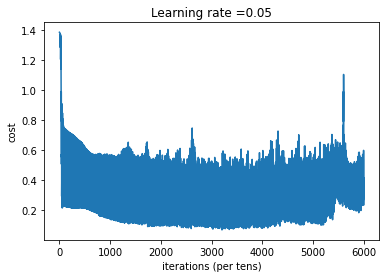

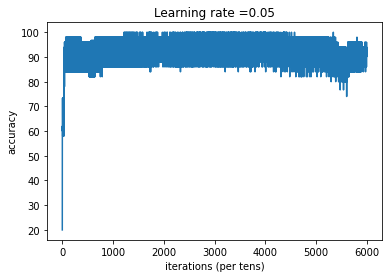

In [235]:

n_x=X_train.shape[0]
layers_dims=[n_x,25,25,2]
ob=Deep_Neural_Network(layers_dims,0.05,1000,True,optimizer="momentum",batchSize=50)
ob.fit(X_train,Y_train_)

In [236]:
b=ob.predict(X_train,y_train)
bb=ob.predict(X_test,y_test)

Training Accuracy : 92.14285714285714 %
Training Accuracy : 87.5 %
